<a href="https://www.kaggle.com/code/ujjwalmalik/augmented-alzheimers-detection-um?scriptVersionId=127855417" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction
Detecting various stages of Alzheimer’s from Alzheimer MRI Dataset. The model is using transfer learning by utilizing the VGG16 pre-trained model with weights from the ImageNet dataset. This allows the model to extract high-level features from the input MRI images, which can then be fed into the custom dense layers for classification. The model is designed to classify Alzheimer's disease into four stages using a SoftMax activation function on the output layer. The use of pre-trained layers and the custom dense layers make the model suitable for handling complex image classification tasks with high accuracy

In [3]:
# !pip install split-folders

In [1]:
#Environment check
import os
import warnings
warnings.filterwarnings("ignore")

In [1]:
#Imports
# import splitfolders
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Dense, BatchNormalization, add, Activation
from tensorflow.keras import optimizers, losses
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools

In [2]:
data = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset"

In [7]:
# splitfolders.ratio(data, output="AugmentedAlzheimerCategorizedDataset", seed=1337, ratio=(0.7, 0.2,0.1))

Copying files: 33984 files [03:48, 148.98 files/s]


# Input Data
The data consists of MRI images. The data has four classes of images both in training as well as a testing set:

1. Mild Demented
2. Moderate Demented
3. Non Demented
4. Very Mild Demented

In [8]:
image_dir = Path(data)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) 

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

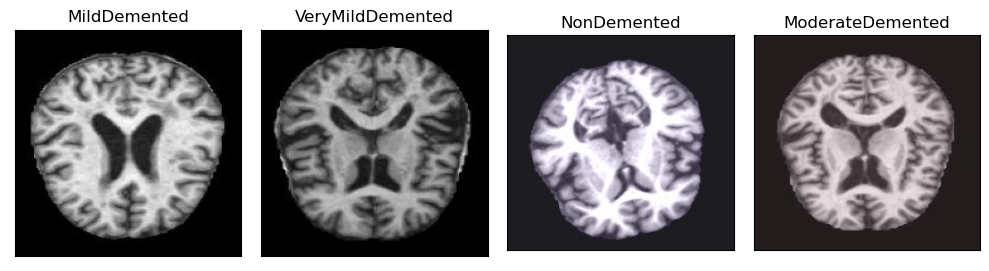

In [12]:
# Displaying 4 random images
random_index = np.random.randint(0, len(image_df), 4)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# Data Augmentation 
Modify the data further to generalize the data

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
    validation_split=0.2
    )

test_datagen = ImageDataGenerator(
    rescale=1./255)

# Segragating the data
Separate the dataset for training, validation and test.

In [4]:
train_dir = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset"
test_dir = "/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset"

# Data Loading

In [7]:
train_images = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

validation_images = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

test_images = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


# Build the ML Model
The model is using transfer learning by utilizing the VGG16 pre-trained model with weights from the ImageNet dataset. This allows the model to extract high-level features from the input MRI images, which can then be fed into the custom dense layers for classification. The model is designed to classify Alzheimer's disease into four stages using a SoftMax activation function on the output layer. The use of pre-trained layers and the custom dense layers make the model suitable for handling complex image classification tasks with high accuracy

In [8]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

# Define the new model with the base model and top layers
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False
    


58889256/58889256 [==============================] - 1s 0us/step


# Training the Model

In [9]:
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history = model.fit(train_images,
    steps_per_epoch=len(train_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=20)

Epoch 1/20
850/850 [==============================] - 314s 358ms/step - loss: 0.6869 - accuracy: 0.7131 - val_loss: 0.4112 - val_accuracy: 0.8381
Epoch 2/20
850/850 [==============================] - 92s 109ms/step - loss: 0.3513 - accuracy: 0.8567 - val_loss: 0.4197 - val_accuracy: 0.8290
Epoch 3/20
850/850 [==============================] - 94s 110ms/step - loss: 0.2652 - accuracy: 0.8923 - val_loss: 0.2445 - val_accuracy: 0.8976
Epoch 4/20
850/850 [==============================] - 90s 106ms/step - loss: 0.2065 - accuracy: 0.9196 - val_loss: 0.2267 - val_accuracy: 0.9097
Epoch 5/20
850/850 [==============================] - 90s 106ms/step - loss: 0.1842 - accuracy: 0.9286 - val_loss: 0.1953 - val_accuracy: 0.9247
Epoch 6/20
850/850 [==============================] - 87s 102ms/step - loss: 0.1454 - accuracy: 0.9449 - val_loss: 0.2720 - val_accuracy: 0.8974
Epoch 7/20
850/850 [==============================] - 91s 107ms/step - loss: 0.1287 - accuracy: 0.9510 - val_loss: 0.2968 - val_a

# Visualize Model Metrics

200/200 [==============================] - 57s 283ms/step


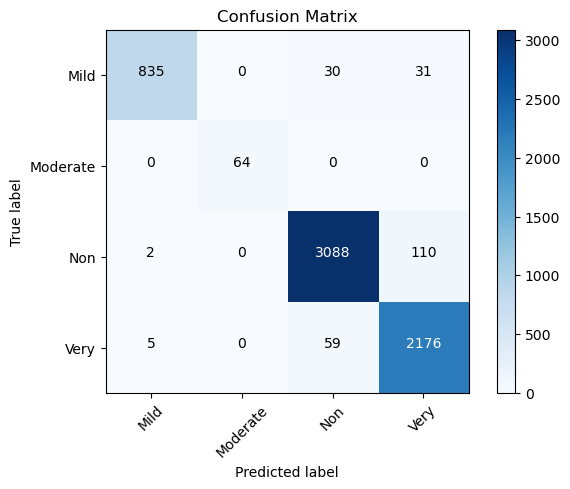

In [10]:
from itertools import product

# Get the predictions for the validation data
Y_pred = model.predict(test_images)

# Convert the predictions from one-hot encoding to labels
y_pred = np.argmax(Y_pred, axis=1)
# Get the true labels for the validation data
y_true = test_images.classes

# Create the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Define the class labels
class_names = ['Mild', 'Moderate', 'Non', 'Very']

# Plot the confusion matrix
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
fmt = 'd'
thresh = confusion_mtx.max() / 2.
for i, j in product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
    plt.text(j, i, format(confusion_mtx[i, j], fmt),
             horizontalalignment="center",
             color="white" if confusion_mtx[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [11]:
print(accuracy_score(y_true, y_pred))
test_accuracy = accuracy_score(y_true, y_pred)

0.96296875


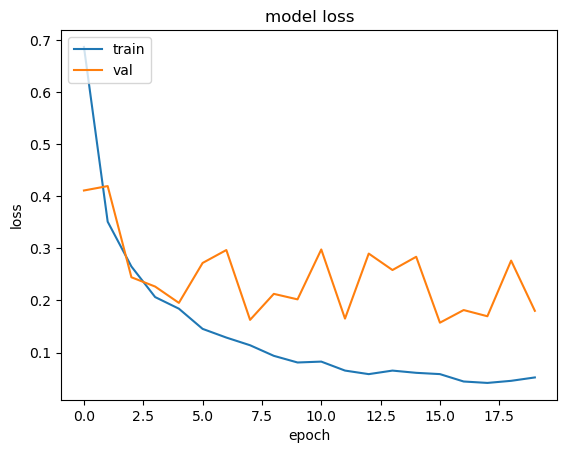

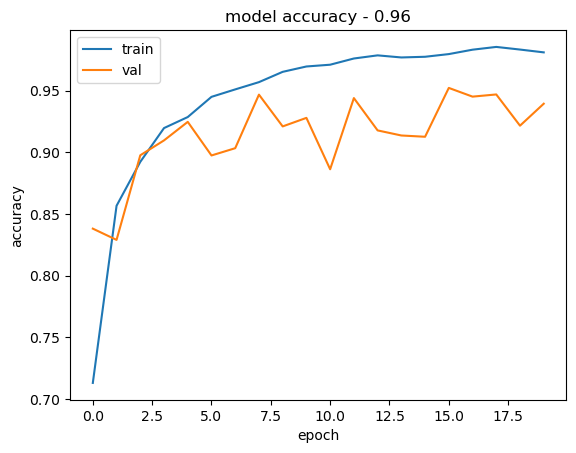

In [12]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy - ' + str(format(test_accuracy, "0.2f")))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()